In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# ——————————————
# 全局设置：支持中文 & 负号
# ——————————————
plt.rcParams['font.sans-serif'] = ['SimHei']      # 或者你的系统里其他可用中文字体
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# —— 0. 读取 & 转换日期列 ——
df = pd.read_csv("dataset_clean.csv")
df["submit_datatime"]  = pd.to_datetime(df["submit_datatime"])
df["player_birthday"]  = pd.to_datetime(df["player_birthday"])

# —— 1.1 派生年龄相关变量 ——
# current_age：直接相减得到 timedelta，再 .dt.days
df["current_age"]      = (df["submit_datatime"] - df["player_birthday"]).dt.days / 365.25
df["experience_yrs"]   = df["play_time_month"] / 12
df["start_age"]        = df["current_age"] - df["experience_yrs"]

# —— 1.2 练习强度指标 ——
df["plays_per_month"]  = df["play_count"] / df["play_time_month"].clip(lower=1)
df["plays_per_year"]   = df["play_count"] / df["experience_yrs"].clip(lower=0.1)

# —— 1.3 标准化打分 ——
df["rating_z"] = (df["player_rating"] - df["player_rating"].mean()) / df["player_rating"].std()


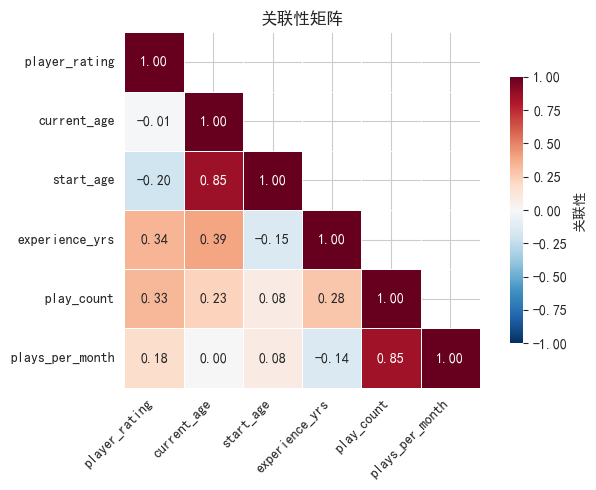

In [14]:
import numpy as np

# —— 2.2 精简 & 美化的相关矩阵热图 ——
features = [
    "player_rating",
    "current_age",
    "start_age",
    "experience_yrs",
    "play_count",
    "plays_per_month"
]

# 计算相关矩阵
corr = df[features].corr()

# 只保留下三角
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)


plt.figure(figsize=(7,5))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75, "label": "关联性"}
)

# 美化坐标与标题
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("关联性矩阵")
plt.tight_layout()
plt.show()


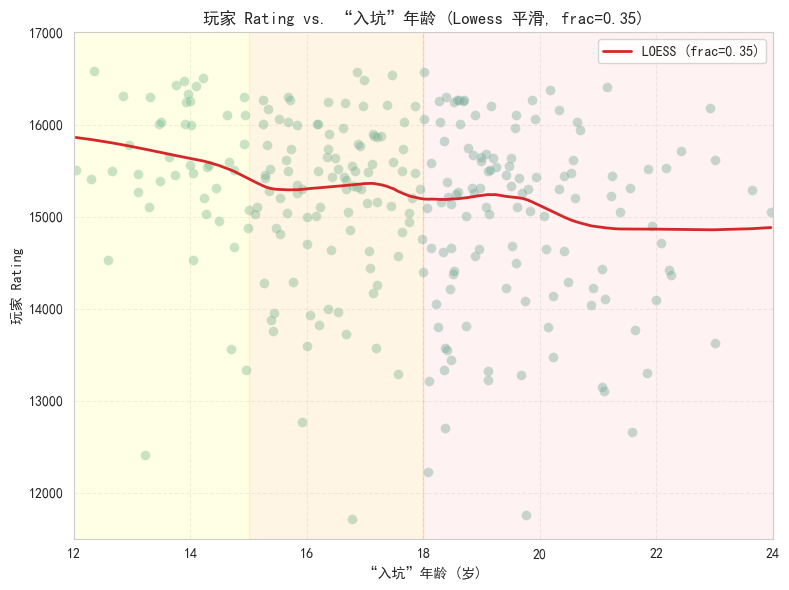

In [57]:
# —— 2.3 Rating vs. Start Age （Lowess）——
from statsmodels.nonparametric.smoothers_lowess import lowess

# 只保留 12–24 岁区间
df2 = df.query("start_age >= 12 and start_age <= 24")

# 1. 画散点
plt.figure(figsize=(8,6))
plt.scatter(
    df2["start_age"],
    df2["player_rating"],
    s=50,
    alpha=0.4,
    color="#69b3a2",
    edgecolor="w",
    linewidth=0.3
)

# 2. 计算 LOESS（frac=0.35）
loess_sm = lowess(
    endog=df2["player_rating"],
    exog=df2["start_age"],
    frac=0.35,
    return_sorted=True
)

# 3. 绘制平滑曲线
plt.plot(
    loess_sm[:,0], loess_sm[:,1],
    color="#d62728",
    linewidth=2,
    label="LOESS (frac=0.35)"
)


# 4. 美化
plt.xlim(12, 24)
plt.ylim(11500, 17000)
plt.xlabel("“入坑”年龄 (岁)")
plt.ylabel("玩家 Rating")
plt.title("玩家 Rating vs. “入坑”年龄 (Lowess 平滑, frac=0.35)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.axvspan(12, 15, color="yellow", alpha=0.1)
plt.axvspan(15, 18, color="orange", alpha=0.1)
plt.axvspan(18, 24, color="red", alpha=0.05)

plt.tight_layout()
plt.show()


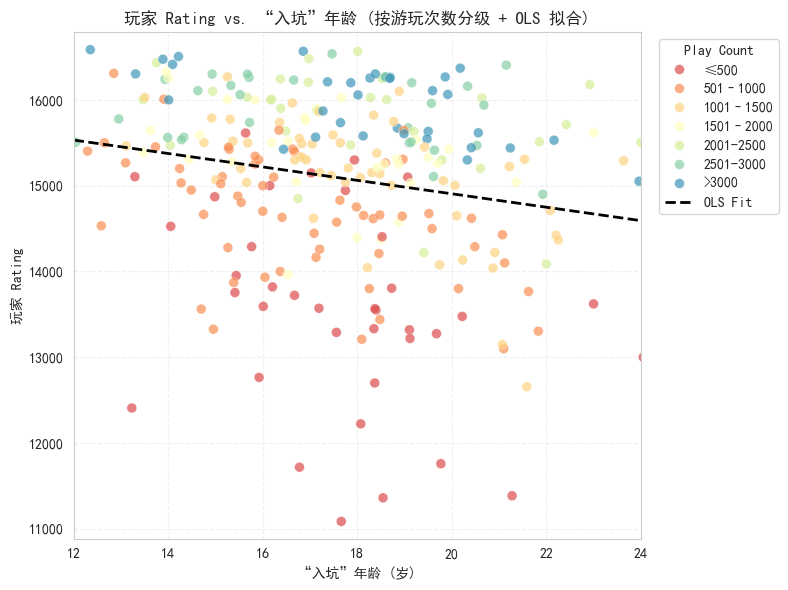

In [56]:
#=======================
# 方案 3：分段上色 & OLS 回归
#=======================
import statsmodels.api as sm

# 假设 df 已包含 start_age, player_rating, play_count

# 1) 对 play_count 进行分箱
bins   = [0, 500, 1000, 1500, 2000, 2500, 3000, np.inf]
labels = ["≤500", "501–1000", "1001–1500", "1501–2000", "2001-2500","2501-3000",">3000"]
df["pc_cat"] = pd.cut(df["play_count"], bins=bins, labels=labels, right=True)

# 2) 绘图
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="start_age",
    y="player_rating",
    hue="pc_cat",
    palette="Spectral",
    alpha=0.7,
    s=50,
    edgecolor="w",
    linewidth=0.3
)

# 3) 叠加 OLS 线性拟合
X = sm.add_constant(df["start_age"])
ols = sm.OLS(df["player_rating"], X).fit()
x0 = np.linspace(12, 24, 100)
y0 = ols.params["const"] + ols.params["start_age"] * x0
plt.plot(x0, y0, color="black", linestyle="--", linewidth=2, label="OLS Fit")

# 4) 美化与注释
plt.xlim(12, 24)
plt.ylim(df["player_rating"].min() - 200, df["player_rating"].max() + 200)
plt.xlabel("“入坑”年龄 (岁)")
plt.ylabel("玩家 Rating")
plt.title("玩家 Rating vs. “入坑”年龄 (按游玩次数分级 + OLS 拟合)")

# 调整图例
plt.legend(title="Play Count", bbox_to_anchor=(1.02,1), loc="upper left", frameon=True)

plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

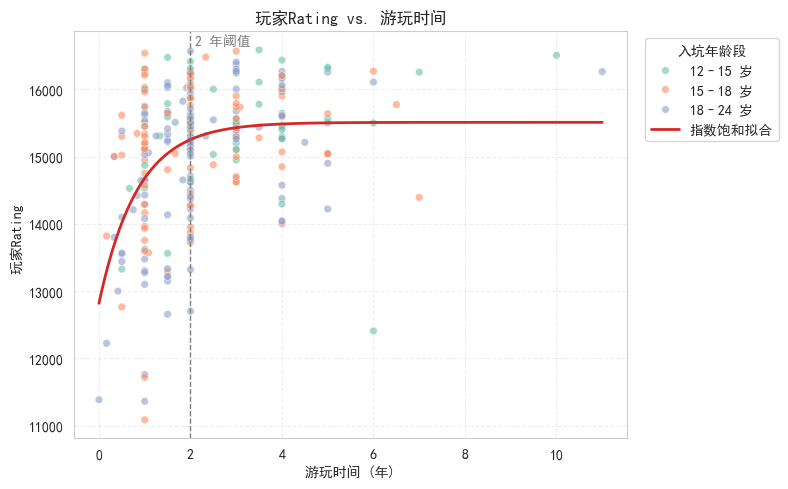

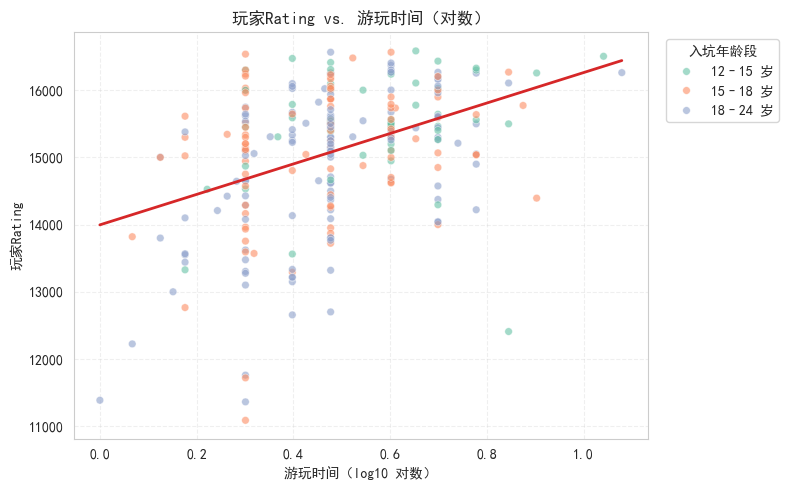

In [69]:

from scipy.optimize import curve_fit
plt.rcParams.update({
    "font.sans-serif": ["SimHei"],    # 支持中文
    "axes.unicode_minus": False       # 负号正常显示
})
# ——————————————————————————————
# 图 1：原始散点 + 指数饱和拟合（提示饱和趋势）
# y = a*(1 - exp(-b*x)) + c
# ——————————————————————————————
df["log_time"] = np.log10(df["experience_yrs"] + 1)

# 按入坑年龄分组
df["age_group"] = pd.cut(
    df["start_age"],
    bins=[0, 15, 18, 30],
    labels=["12–15 岁", "15–18 岁", "18–24 岁"]
)

# 定义饱和函数
def saturating(x, a, b, c):
    return a * (1 - np.exp(-b * x)) + c

# 拟合参数
popt, _ = curve_fit(
    saturating,
    df["experience_yrs"],
    df["player_rating"],
    p0=[5000, 1, 10000],
    maxfev=10000
)

# 饱和拟合曲线
x_fit = np.linspace(0, df["experience_yrs"].max(), 200)
y_fit = saturating(x_fit, *popt)

# —— 图 1：指数饱和 拟合（点按年龄分色） ——
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df, x="experience_yrs", y="player_rating",
    hue="age_group", palette="Set2",
    s=30, alpha=0.6
)
plt.plot(x_fit, y_fit, color="#d62728", lw=2, label="指数饱和拟合")
plt.axvline(2, color="gray", linestyle="--", lw=1)
plt.text(2.1, plt.ylim()[1]-200, "2 年阈值", color="gray")

plt.xlabel("游玩时间 (年)")
plt.ylabel("玩家Rating ")
plt.title("玩家Rating vs. 游玩时间")
plt.legend(title="入坑年龄段", bbox_to_anchor=(1.02,1), loc="upper left")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()


# —— 图 2：对数坐标 + 线性拟合（点按年龄分色） ——
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df, x="log_time", y="player_rating",
    hue="age_group", palette="Set2",
    s=30, alpha=0.6
)
sns.regplot(
    data=df, x="log_time", y="player_rating",
    scatter=False, ci=None, color="#d62728", line_kws={"lw":2}
)

plt.xlabel("游玩时间（log10 对数）")
plt.ylabel("玩家Rating")
plt.title("玩家Rating vs. 游玩时间（对数）")
plt.legend(title="入坑年龄段", bbox_to_anchor=(1.02,1), loc="upper left")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

In [7]:
# —— 3.1 回归：基准模型（加入 play_count） ——
m0 = smf.ols(
    "player_rating ~ play_time_month + play_count",
    data=df
).fit()
print("\nBaseline model (m0):")
print(m0.summary())

# —— 3.2 加入年龄项 ——
m1 = smf.ols(
    "player_rating ~ play_time_month + play_count + current_age + start_age",
    data=df
).fit()
print("\nCompare m1 vs m0 (F-test ΔR²):", m1.compare_f_test(m0))
print(m1.summary())

# —— 3.3 交互：start_age × play_count ——
m2 = smf.ols(
    "player_rating ~ play_time_month + play_count + current_age + start_age + start_age:play_count",
    data=df
).fit()
print("\nInteraction model (m2):")
print(m2.summary())



Baseline model (m0):
                            OLS Regression Results                            
Dep. Variable:          player_rating   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     28.42
Date:                Fri, 13 Jun 2025   Prob (F-statistic):           6.16e-12
Time:                        20:35:32   Log-Likelihood:                -2279.7
No. Observations:                 276   AIC:                             4565.
Df Residuals:                     273   BIC:                             4576.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         1.

In [8]:
# —— 4. 随机森林：评估各特征重要度 ——
X = df[[
    "play_time_month","play_count","current_age",
    "start_age","plays_per_month","plays_per_year"
]].fillna(0)
y = df["player_rating"]

rf = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(n_estimators=500, random_state=42))
])
cv_r2 = cross_val_score(rf, X, y, scoring="r2", cv=5).mean()
rf.fit(X, y)
importances = rf.named_steps["rf"].feature_importances_

print(f"\nRandom Forest CV R² = {cv_r2:.3f}")
print("Feature importances:")
for feat, imp in zip(X.columns, importances):
    print(f"  {feat:<15} {imp:.3f}")



Random Forest CV R² = 0.591
Feature importances:
  play_time_month 0.027
  play_count      0.719
  current_age     0.072
  start_age       0.110
  plays_per_month 0.036
  plays_per_year  0.036


XGBoost CV R² = 0.538
XGBoost 特征重要度：
play_count         0.517963
start_age          0.155569
play_time_month    0.114528
current_age        0.106219
plays_per_month    0.105720
dtype: float32


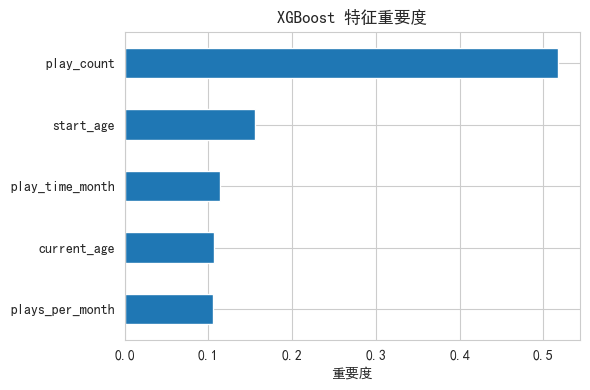

In [78]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# 准备特征和目标
X = df[[
    "play_time_month",
    "play_count",
    "current_age",
    "start_age",
    "plays_per_month",
]].fillna(0)
y = df["player_rating"]

# 定义 XGBoost 回归管道
xgb_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBRegressor(
        n_estimators=400,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.6,
        random_state=42,
        objective="reg:squarederror"
    ))
])

# 5 折交叉验证 R²
cv_r2_xgb = cross_val_score(xgb_pipe, X, y, scoring="r2", cv=5).mean()
print(f"XGBoost CV R² = {cv_r2_xgb:.3f}")

# 训练全模型并提取特征重要度
xgb_pipe.fit(X, y)
importances = xgb_pipe.named_steps["xgb"].feature_importances_

# 整理并输出
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print("XGBoost 特征重要度：")
print(feat_imp)

# （可选）绘制条形图
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
feat_imp.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("XGBoost 特征重要度")
plt.xlabel("重要度")
plt.tight_layout()
plt.show()

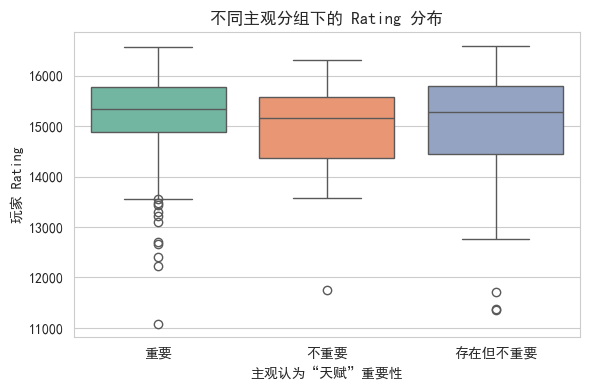

In [9]:
# —— 5. Question1 对比分布 ——
plt.figure(figsize=(6, 4))
# 1) 方式一：不指定 palette，而用 color 指定单色
# sns.boxplot(x="Question1", y="player_rating", data=df, color="skyblue")

# 2) 方式二：如果你还想要不同颜色，需要把 x 也当 hue
sns.boxplot(
    x="Question1",
    y="player_rating",
    hue="Question1",
    data=df,
    palette="Set2",
    dodge=False,      # 保证每个 x 只画一组箱线
    legend=False
)
plt.xticks([0, 1, 2], ["重要", "不重要", "存在但不重要"])
plt.xlabel("主观认为“天赋”重要性")
plt.ylabel("玩家 Rating")
plt.title("不同主观分组下的 Rating 分布")
plt.tight_layout()
plt.show()